In [1]:
from qite import *
from helper import *
%matplotlib inline
import matplotlib.pyplot as plt

from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere

unit_sim = Aer.get_backend('unitary_simulator')

def get_matrix(qc):
    job = execute(qc, unit_sim)
    result = job.result()
    return np.asarray(result.get_unitary(qc))

def cull(a):
    b = np.where(np.abs(a) < 1e-5, 0, a)
    r = np.where( np.abs(np.real(b)) < 1e-5, 0, np.real(b) )
    i = np.where( np.abs(np.imag(b)) < 1e-5, 0, np.imag(b) )
    return r + 1j*i

In [2]:
def m(qc, idx, qbits, cbits, backend, num_shots=1024):
    if idx == 0:
        return 1

    nbits = len(qbits)
    ids = int_to_base4(idx, nbits)

    measures = []

    for i in range(nbits):
        if ids[i] == 0:
            # I only has +1 eigenvalues, so the measurement is +1
            continue
        elif ids[i] == 1:
            # Rotate to X-basis
            qc.h(qbits[i])
        elif ids[i] == 2:
            # Rotate to Y-basis
            qc.rx(-np.pi/2, qbits[i])
        elif ids[i] == 3:
            # Already in Z-basis
            None
        else:
            raise ValueError('Only 0,1,2,3 are valid idx')
        measures.append( [qbits[i],cbits[i]] )

    # print(measures)
    # Add measurements to the circuit
    for m in measures:
        qc.measure(m[0],m[1])

    # Get the measurement statistics
    counts = run_circuit(qc, backend, num_shots=num_shots)

    expectation = 0
    for key in counts.keys():
        k = key.replace(' ','')
        sign = 1
        # print('key: ', k)
        for m in measures:
            if k[-(m[1] + 1)] == '1':
                sign *= -1
        expectation += sign*counts[key]

    expectation /= num_shots
    return expectation, counts



In [3]:
x = 64*3
nbits = 4
p = int_to_base4(x,nbits)
qc = QuantumCircuit(nbits,nbits)
theta = 0
qbits = list(range(nbits))
# pauli_exp(qc,qbits,x,theta)

qc.x(nbits-1)

print(p)
qc.barrier()
ex,counts = m(qc,x,qbits,qbits,aer_sim)
print(ex)
qc.draw()

[0, 0, 0, 3]
-1.0


░    
q_0: ──────░────
           ░    
q_1: ──────░────
           ░    
q_2: ──────░────
     ┌───┐ ░ ┌─┐
q_3: ┤ X ├─░─┤M├
     └───┘ ░ └╥┘
c: 4/═════════╩═
              3

dict_keys(['1000'])


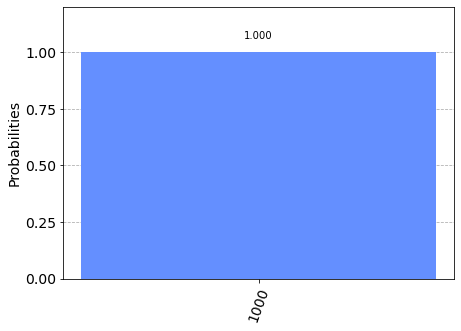

In [5]:
from qiskit.visualization import plot_histogram
print(counts.keys())
plot_histogram(counts)

In [21]:
def propogate_mult(qc, alist, qbits):
    nbits = len(qbits)
    for t in range(len(alist)):
        for gate in range(1,4**nbits):
            angle = np.real(alist[t][gate])
            if np.abs(angle) > 1e-5:
                pauli_exp(qc,qbits,gate,angle)


In [47]:
hm_list = []
hm_list.append([])
hm_list[0].append([[1],[1/np.sqrt(2)]])
hm_list.append([])
hm_list[1].append([[3],[1/np.sqrt(2)]])

def base4_to_int(pauli):
    x = 0
    for i in range(len(pauli)):
        x += pauli[i] * 4**i
    return x

def pauli_prod(p1,p2,nbits):
    pauli1 = int_to_base4(p1,nbits)
    pauli2 = int_to_base4(p2,nbits)
    
    c = 1+0.j
    prod = [0]*nbits
    
    for i in range(nbits):
        prod[i] = idx[pauli1[i], pauli2[i]]
        c  *= coeff[pauli1[i], pauli2[i]]
    
    return base4_to_int(prod), c

def update_alist_mult(sigma_expectation, alist, db, delta, hm):
    # number of pauli terms in hm
    nterms = len(hm[0][0])
    # number of qubits the hm term acts on
    nbits = len(hm[0][2])
    # number of pauli strings on that many qubits
    nops = 4**nbits
    
    # Step 1: Obtain S matrix
    S = np.zeros([nops,nops],dtype=complex)
    for i in range(nops):
        for j in range(nops):
            p,c_ = pauli_prod(i,j)
            S[i,j] =  sigma_expectation[p] * c_
            
    # Step 2: Obtain b vector
    b = np.zeros(nops,dtype=complex)
    c = 1
    
    for i in range(nterms):
        c -= 2 * db * hm[0][1][i] * sigma_expectation[hm[0][0][i]]
    c = np.sqrt(c)
    
    for i in range(nops):
        b[i] += ( sigma_expectation[i]/c - sigma_expectation[i] ) / db
        for j in range(nterms):
            p,c_ = pauli_prod(i,hm[0][0][j])
            b[i] -= hm[0][1][j] * c_ * sigma_expectation[p] / c
    b = 1j * (b - np.conj(b))
    
    # Step 3: Add regularizer
    dalpha = np.eye(nops)*delta
    
    # Step 4: Solve for linear equation, the solutions is multiplies by -2 because of the definition of unitary rotations is exp(-i theta/2)
    x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]
    alist.append([])
    for i in range(len(x)):
        alist[-1].append(-x[i]*2*db)
        
    return c
    
alist = []
db = 0.1
delta = 0.01

# print(hm_list)
# hm = hm_list[0]
# print(hm)
# print(hm[0][0])

p1 = base4_to_int([1,2,0,0])
p2 = base4_to_int([2,3,0,0])

pauli_prod(p1,p2,4)

(7, (-1+0j))

In [7]:
print(fd / np.exp(1j*theta/2))

NameError: name 'fd' is not defined

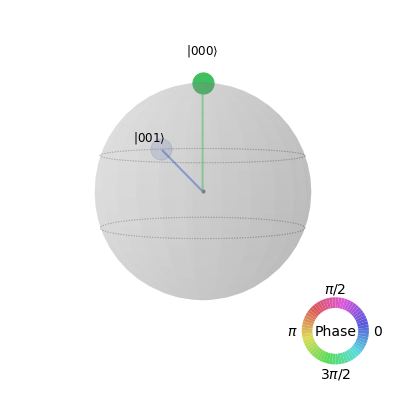

In [114]:
plot_state_qsphere(init_sv)

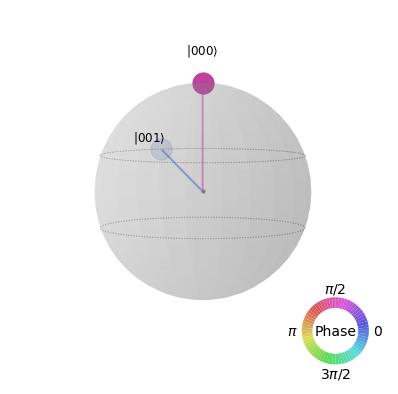

In [115]:
plot_state_qsphere(evolved_sv)

In [94]:
qc1 = QuantumCircuit(1)
qc2 = QuantumCircuit(1)
qc3 = QuantumCircuit(1)

qc1.ry(theta, 0)

qc2.rx(np.pi/2, 0)
qc2.rz(theta, 0)
qc2.rx(-np.pi/2, 0)


qc3.rx(np.pi/2, 0)
qc3.s(0)
qc3.rz(theta, 0)
qc3.sdg(0)
qc3.rx(-np.pi/2, 0)

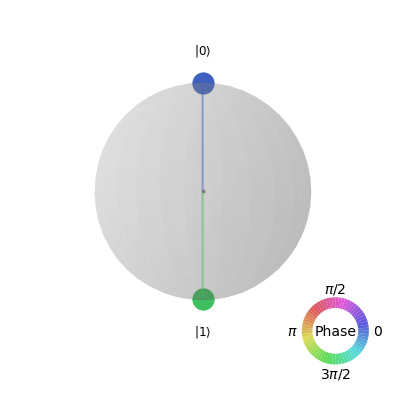

In [103]:
init_sv = Statevector([np.sqrt(0.5), -1j*np.sqrt(0.5)])
plot_state_qsphere(init_sv)

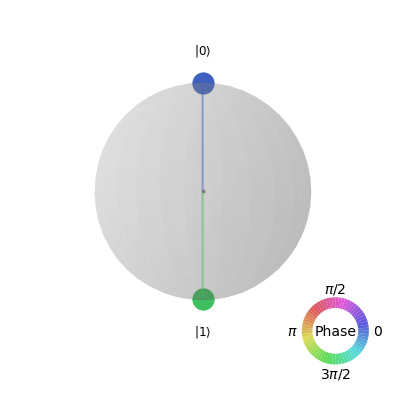

In [104]:
sv1 = init_sv.evolve(qc1)
plot_state_qsphere(sv1)

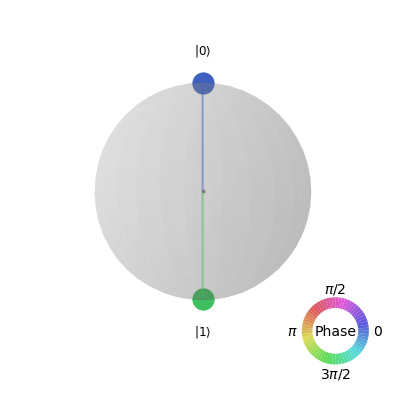

In [105]:
sv2 = init_sv.evolve(qc2)
plot_state_qsphere(sv2)

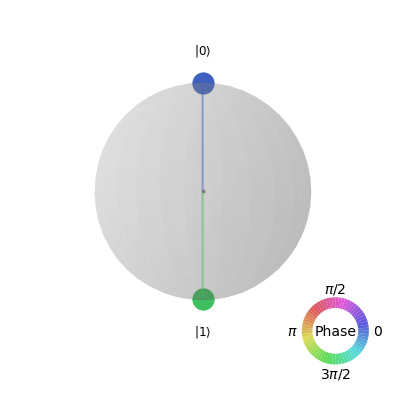

In [106]:
sv3 = init_sv.evolve(qc3)
plot_state_qsphere(sv3)

In [118]:
from qiskit import Aer

#Changing the simulator 
unit_sim = Aer.get_backend('unitary_simulator')

In [125]:
job = execute(qc, backend)
result = job.result()

#get the unitary matrix from the result object
u = np.asarray(result.get_unitary(qc))
u.shape

(8, 8)

In [127]:
u

array([[-2.29934717e-17-0.70710678j,  2.29934717e-17-0.70710678j,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 2.29934717e-17-0.70710678j, -3.25176795e-17+0.70710678j,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        -2.29934717e-17-0.70710678j,  2.29934717e-17-0.70710678j,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         2.29934717e-17-0.70710678j, -3.25176795e-17+0.70710678j,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
       

In [129]:
init_sv.data

array([7.07106781e-01+2.29934717e-17j, 2.29934717e-17+7.07106781e-01j,
       0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j])

In [46]:
qc = QuantumCircuit(1)
theta = np.pi/4
qc.ry(theta,0)

u_ry = get_matrix(qc)
print(u_ry)

[[ 0.92387953+0.j -0.38268343+0.j]
 [ 0.38268343+0.j  0.92387953+0.j]]


In [47]:
qc = QuantumCircuit(2)
qc.ry(theta,0)
u_ry2 = get_matrix(qc)
print(u_ry2)

[[ 0.92387953+0.j -0.38268343+0.j  0.        +0.j  0.        +0.j]
 [ 0.38268343+0.j  0.92387953+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.92387953+0.j -0.38268343+0.j]
 [ 0.        +0.j  0.        +0.j  0.38268343+0.j  0.92387953+0.j]]


In [48]:
qc = QuantumCircuit(2)
qc.rx(np.pi/2, 0)
# qc.s(0)
qc.rz(theta,0)
# qc.sdg(0)
qc.rx(-np.pi/2,0)

u = get_matrix(qc)
print(u)

[[ 0.92387953+0.j -0.38268343+0.j  0.        +0.j  0.        +0.j]
 [ 0.38268343+0.j  0.92387953+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.92387953+0.j -0.38268343+0.j]
 [ 0.        +0.j  0.        +0.j  0.38268343+0.j  0.92387953+0.j]]


In [49]:
print(cull(u-u_ry2))

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [120]:
theta = np.pi/2
qc = QuantumCircuit(3)

#change basis (XYZ)
qc.h(0)
qc.rx(np.pi/2,1)
qc.s(1)

# cascading CNOTs
qc.cx(0,1)
qc.cx(1,2)

# rotate
qc.rz(theta, 2)

# undo CNOTs
qc.cx(1,2)
qc.cx(0,1)

# undo basis change
qc.h(0)
qc.sdg(1)
qc.rx(-np.pi/2,1)

qc.draw()

┌───┐                                        ┌───┐             
q_0: ───┤ H ├──────────■─────────────────────────■───┤ H ├─────────────
     ┌──┴───┴──┐┌───┐┌─┴─┐                     ┌─┴─┐┌┴───┴┐┌──────────┐
q_1: ┤ Rx(π/2) ├┤ S ├┤ X ├──■───────────────■──┤ X ├┤ Sdg ├┤ Rx(-π/2) ├
     └─────────┘└───┘└───┘┌─┴─┐┌─────────┐┌─┴─┐└───┘└─────┘└──────────┘
q_2: ─────────────────────┤ X ├┤ Rz(π/2) ├┤ X ├────────────────────────
                          └───┘└─────────┘└───┘

In [121]:
u = get_matrix(qc)
print(cull(u))

[[ 0.70710678+0.j  0.        +0.j  0.        +0.j -0.70710678+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j -0.70710678+0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.70710678+0.j  0.        +0.j  0.        +0.j  0.70710678+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.70710678+0.j  0.        +0.j  0.        +0.j  0.70710678+0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j -0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  -

In [122]:
init = QuantumCircuit(3)

init.initialize(np.sqrt(0.5)*np.array([1,-1]),0)
init.initialize(np.sqrt(0.5)*np.array([1,-1j]),1)
init.initialize([0,1],2)

sv = Statevector.from_label('000').evolve(init)
print(cull(sv.data))
init.draw()

[ 0. +0.j   0. +0.j   0. +0.j   0. +0.j   0.5+0.j  -0.5+0.j   0. -0.5j
  0. +0.5j]


┌──────────────────────────────┐
q_0: ─┤ Initialize(0.70711,-0.70711) ├
     ┌┴──────────────────────────────┤
q_1: ┤ Initialize(0.70711,-0.70711j) ├
     └──────┬─────────────────┬──────┘
q_2: ───────┤ Initialize(0,1) ├───────
            └─────────────────┘

In [123]:
final_sv = sv.evolve(qc)
print(cull(final_sv.data))

[ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.35355339+0.35355339j -0.35355339-0.35355339j
  0.35355339-0.35355339j -0.35355339+0.35355339j]


In [124]:
print('exp(-i theta/2)?', cull(final_sv.data / np.exp(-1j*theta/2) - sv.data ))
print('exp(+i theta/2)?', cull(final_sv.data / np.exp(+1j*theta/2) - sv.data ))

exp(-i theta/2)? [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j  -0.5+0.5j  0.5-0.5j  0.5+0.5j
 -0.5-0.5j]
exp(+i theta/2)? [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [158]:
init_states = np.asarray([
    [ np.array([1,1])*np.sqrt(0.5), np.array([1,-1])*np.sqrt(0.5) ],
    [ np.array([1,1j])*np.sqrt(0.5), np.array([1,-1j])*np.sqrt(0.5) ],
    [ [1,0], [0,1] ],
])
# print(init_states.shape)

init_svs  = []
final_svs = []

theta = np.pi/4

qc = QuantumCircuit(3)
pauli_exp(qc, [0,1,2], 16*2+4*0+1*3, theta)
qc.draw()

for i in range(2):
    for j in range(2):
        for k in range(2):
            init = QuantumCircuit(3)
            init.initialize(init_states[1][i], 0)
            init.initialize(init_states[1][j], 1)
            init.initialize(init_states[2][k], 2)
            
            eigval = np.exp((-1)**(i+k+1) * 1j * theta/2)
#             print('{}+{}+{}+1 -->'.format(i,j,k),(i+j+k+1) % 2,'sign:',((-1)**(i+j+k+1)) , 'eigval:', eigval)
            
            init_sv = Statevector.from_label('000').evolve(init)
            init_svs.append(init_sv)
            final_sv = init_sv.evolve(qc)
            final_svs.append(final_sv.data/eigval)

init_svs = np.asarray(init_svs)
final_svs = np.asarray(final_svs)

qc.draw()

┌─────────┐                     ┌──────────┐
q_0: ┤ Rx(π/2) ├──■───────────────■──┤ Rx(-π/2) ├
     └─────────┘  │               │  └──────────┘
q_1: ─────────────┼───────────────┼──────────────
                ┌─┴─┐┌─────────┐┌─┴─┐            
q_2: ───────────┤ X ├┤ Rz(π/4) ├┤ X ├────────────
                └───┘└─────────┘└───┘

In [159]:
cull(final_svs)

array([[ 0.5+0.j ,  0. +0.5j,  0. +0.5j, -0.5+0.j ,  0. +0.j ,  0. +0.j ,
         0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. +0.5j,
         0. +0.5j, -0.5+0.j ],
       [ 0.5+0.j ,  0. +0.5j,  0. -0.5j,  0.5+0.j ,  0. +0.j ,  0. +0.j ,
         0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. +0.5j,
         0. -0.5j,  0.5+0.j ],
       [ 0.5+0.j ,  0. -0.5j,  0. +0.5j,  0.5+0.j ,  0. +0.j ,  0. +0.j ,
         0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. -0.5j,
         0. +0.5j,  0.5+0.j ],
       [ 0.5+0.j ,  0. -0.5j,  0. -0.5j, -0.5+0.j ,  0. +0.j ,  0. +0.j ,
         0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. -0.5j,
         0. -0.5j, -0.5+0.j ]])

In [160]:
cull(init_svs)

array([[ 0.5+0.j ,  0. +0.5j,  0. +0.5j, -0.5+0.j ,  0. +0.j ,  0. +0.j ,
         0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. +0.5j,
         0. +0.5j, -0.5+0.j ],
       [ 0.5+0.j ,  0. +0.5j,  0. -0.5j,  0.5+0.j ,  0. +0.j ,  0. +0.j ,
         0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. +0.5j,
         0. -0.5j,  0.5+0.j ],
       [ 0.5+0.j ,  0. -0.5j,  0. +0.5j,  0.5+0.j ,  0. +0.j ,  0. +0.j ,
         0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. -0.5j,
         0. +0.5j,  0.5+0.j ],
       [ 0.5+0.j ,  0. -0.5j,  0. -0.5j, -0.5+0.j ,  0. +0.j ,  0. +0.j ,
         0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. -0.5j,
         0. -0.5j, -0.5+0.j ]])

In [161]:
cull(final_svs - init_svs)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [141]:
pi = np.pi
Rx = np.array([
    [np.cos(-pi/4),     -1j*np.sin(-pi/4)],
    [-1j*np.sin(-pi/4), np.cos(-pi/4)]
],dtype=complex)
Rxdg = Rx.T.conj()

S = np.array([
    [1, 0],
    [0, 1j]
], dtype=complex)
Sdg = S.T.conj()

Rz = np.array([
    [np.exp(-1j*theta/2),0],
    [0, np.exp(1j*theta/2)]
], dtype=complex)

In [142]:
Rxdg@Sdg@Rz@S@Rx

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [-0.70710678+0.j,  0.70710678+0.j]])

In [143]:
Rxdg@Rz@Rx

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [-0.70710678+0.j,  0.70710678+0.j]])

In [54]:
qc = QuantumCircuit(4,4)
qbits = [0,1,2,3]
cbits = [0,1,2,3]

# just to see which one is qbit 3:
# qc.h(1)
# qc.rx(np.pi/2,2)
# qc.x(3)

idx = 1*0 + 4*1 + 16*2 + 64*3 # (Measure I0 X1 Y2 Z3)

backend = aer_sim
num_shots = 1000

def meaure_mult(qc, idx, qbits, cbits, backend, num_shots=1024):
    nbits = len(qbits)
    ids = int_to_base4(idx, nbits)

    measures = []

    for i in range(nbits):
        if ids[-(i+1)] == 0:
            # I only has +1 eigenvalues, so the measurement is +1
            continue
        elif ids[-(i+1)] == 1:
            # Rotate to X-basis
            qc.h(qbits[i])
        elif ids[-(i+1)] == 2:
            # Rotate to Y-basis
            qc.rx(-np.pi/2, qbits[i])
        elif ids[-(i+1)] == 3:
            # Already in Z-basis
            None
        else:
            raise ValueError('Only 0,1,2,3 are valid idx')
        measures.append( [qbits[i],cbits[i]] )

#     print(measures)
    # Add measurements to the circuit
    for m in measures:
        qc.measure(m[0],m[1])

    # Get the measurement statistics
    counts = run_circuit(qc, backend, num_shots=num_shots)

    expectation = 0
    for key in counts.keys():
        k = key.replace(' ','')
        sign = 1
#         print('key: ', k)
        for m in measures:
            if k[-(m[1] + 1)] == '1':
                sign *= -1
        expectation += sign*counts[key]

    expectation /= num_shots
    return expectation

exp = meaure_mult(qc, idx, qbits, cbits, backend)
qc.draw()

q_0: ──────────────────
        ┌───┐    ┌─┐   
q_1: ───┤ H ├────┤M├───
     ┌──┴───┴───┐└╥┘┌─┐
q_2: ┤ Rx(-π/2) ├─╫─┤M├
     └───┬─┬────┘ ║ └╥┘
q_3: ────┤M├──────╫──╫─
         └╥┘      ║  ║ 
c: 4/═════╩═══════╩══╩═
          3       1  2

In [16]:
nbits = len(qbits)
ids = int_to_base4(idx, nbits)

measures = []

for i in range(nbits):
    if ids[-(i+1)] == 0:
        # I only has +1 eigenvalues, so the measurement is +1
        continue
    elif ids[-(i+1)] == 1:
        # Rotate to X-basis
        qc.h(qbits[i])
    elif ids[-(i+1)] == 2:
        # Rotate to Y-basis
        qc.rx(-np.pi/2, qbits[i])
    elif ids[-(i+1)] == 3:
        # Already in Z-basis
        None
    else:
        raise ValueError('Only 0,1,2,3 are valid idx')
    measures.append( [qbits[i],cbits[i]] )
   
qc.barrier()

print(measures)
for m in measures:
    qc.measure(m[0],m[1])

# Add the measurement to the circuit
qc.measure([m[0] for m in measures], [m[1] for m in measures])
# # Get the measurement statistics
# counts = run_circuit(qc, backend, num_shots=num_shots)

# # Find the index of cbit in the circuit's classical bits
# index = 0
# for bit in qc.clbits:
#     if bit == cbit:
#         break
#     index += 1


# expectation = 0

# # Loop through the counts
# for key in counts.keys():
#     k = key.replace(' ', '')
#     # Add the +1 eigenvalue measurements
#     if k[-(index+1)] == '0':
#         expectation += counts[key]
#     # Add the -1 eigenvalue measurements
#     else:
#         expectation -= counts[key]

# # Divide by total shots to get the statistical expectation of the measurement
# return float(expectation)/num_shots

qc.draw()

[[1, 1], [2, 2], [3, 3]]


░                   
q_0: ─────────────░───────────────────
        ┌───┐     ░ ┌─┐      ┌─┐      
q_1: ───┤ H ├─────░─┤M├──────┤M├──────
     ┌──┴───┴───┐ ░ └╥┘┌─┐   └╥┘┌─┐   
q_2: ┤ Rx(-π/2) ├─░──╫─┤M├────╫─┤M├───
     └──────────┘ ░  ║ └╥┘┌─┐ ║ └╥┘┌─┐
q_3: ─────────────░──╫──╫─┤M├─╫──╫─┤M├
                  ░  ║  ║ └╥┘ ║  ║ └╥┘
c: 4/════════════════╩══╩══╩══╩══╩══╩═
                     1  2  3  1  2  3

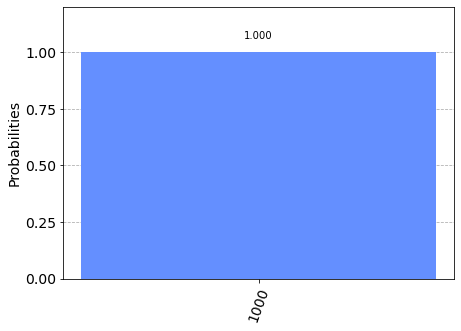

In [47]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [48]:
expectation = 0
for key in counts.keys():
    k = key.replace(' ','')
    sign = 1
    print('key: ', k)
    for m in measures:
        if k[-(m[1] + 1)] == '1':
            sign *= -1
    expectation += sign*counts[key]

expectation /= num_shots
print(expectation)

key:  1000
-1.0


In [52]:
u = get_matrix(qc)
print(cull(u))

[[ 0.92387953+0.j  0.        +0.j  0.        +0.j -0.38268343+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.92387953+0.j -0.38268343+0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.38268343+0.j  0.92387953+0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.38268343+0.j  0.        +0.j  0.        +0.j  0.92387953+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.92387953+0.j  0.        +0.j  0.        +0.j  0.38268343+0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.92387953+0.j  0.38268343+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j -0.38268343+0.j  0.92387953+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  -